In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *

In [ ]:
#default_exp callback.progress

# Progress and logging callbacks

> Callback and helper function to track progress of training or log results

In [ ]:
from local.utils.test import *

## ProgressCallback -

In [ ]:
@docs
class ProgressCallback(Callback):
    "A `Callback` to handle the display of progress bars"
    order = 30 #needs to run after the Recorder
    def begin_fit(self):
        assert hasattr(self.learn, 'recorder')
        self.mbar = master_bar(list(range(self.n_epoch)))
        self.mbar.on_iter_begin()
        self.old_logger,self.learn.logger = self.logger,self._write_stats
        self._write_stats(self.recorder.metric_names)
    
    def begin_epoch(self):    self.mbar.update(self.epoch)
    def begin_train(self):    self._launch_pbar()
    def begin_validate(self): self._launch_pbar()
    def after_train(self):    self.pbar.on_iter_end()
    def after_validate(self): self.pbar.on_iter_end()
    def after_batch(self):    self.pbar.update(self.iter+1)
        
    def _launch_pbar(self):
        self.pbar = progress_bar(self.dl, parent=self.mbar)
        self.pbar.update(0)
        
    def after_fit(self):      
        self.mbar.on_iter_end()
        self.learn.logger = self.old_logger
    
    def _write_stats(self, log):
        self.mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in log], table=True)
        
    _docs = dict(begin_fit="Setup the master bar over the epochs",
                 begin_epoch="Update the master bar",
                 begin_train="Launch a progress bar over the training dataloader",
                 begin_validate="Launch a progress bar over the validation dataloader",
                 after_train="Close the progress bar over the training dataloader",
                 after_validate="Close the progress bar over the validation dataloader",
                 after_batch="Update the current progress bar",
                 after_fit="Close the master bar")
        
defaults.callbacks = [TrainEvalCallback, Recorder, ProgressCallback]

In [ ]:
learn = synth_learner()
learn.fit(5)

epoch,train_loss,valid_loss,time
0,15.008095,1.801413,00:00
1,1.231619,2.823749,00:00
2,2.046385,0.354510,00:00
3,0.135403,0.231188,00:00
4,0.227081,0.060498,00:00


In [ ]:
#hide
assert not learn.progress.mbar.child.is_active
lines = learn.progress.mbar.lines
test_eq(learn.recorder.metric_names, lines[0])
for i,(l,v) in enumerate(zip(lines[1:],learn.recorder.values)):
    test_eq(l[:-1], [str(i)] + [f'{x:.6f}' for x in v])

In [ ]:
show_doc(ProgressCallback.begin_fit)

<h4 id="<code>ProgressCallback.begin_fit</code>" class="doc_header"><code>ProgressCallback.begin_fit</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_fit</code>()

Setup the master bar over the epochs

In [ ]:
show_doc(ProgressCallback.begin_epoch)

<h4 id="<code>ProgressCallback.begin_epoch</code>" class="doc_header"><code>ProgressCallback.begin_epoch</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_epoch</code>()

Update the master bar

In [ ]:
show_doc(ProgressCallback.begin_train)

<h4 id="<code>ProgressCallback.begin_train</code>" class="doc_header"><code>ProgressCallback.begin_train</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_train</code>()

Launch a progress bar over the training dataloader

In [ ]:
show_doc(ProgressCallback.begin_validate)

<h4 id="<code>ProgressCallback.begin_validate</code>" class="doc_header"><code>ProgressCallback.begin_validate</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L14" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.begin_validate</code>()

Launch a progress bar over the validation dataloader

In [ ]:
show_doc(ProgressCallback.after_batch)

<h4 id="<code>ProgressCallback.after_batch</code>" class="doc_header"><code>ProgressCallback.after_batch</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L17" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_batch</code>()

Update the current progress bar

In [ ]:
show_doc(ProgressCallback.after_train)

<h4 id="<code>ProgressCallback.after_train</code>" class="doc_header"><code>ProgressCallback.after_train</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_train</code>()

Close the progress bar over the training dataloader

In [ ]:
show_doc(ProgressCallback.after_validate)

<h4 id="<code>ProgressCallback.after_validate</code>" class="doc_header"><code>ProgressCallback.after_validate</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L16" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_validate</code>()

Close the progress bar over the validation dataloader

In [ ]:
show_doc(ProgressCallback.after_fit)

<h4 id="<code>ProgressCallback.after_fit</code>" class="doc_header"><code>ProgressCallback.after_fit</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L23" class="source_link" style="float:right">[source]</a></h4>

> <code>ProgressCallback.after_fit</code>()

Close the master bar

## ShowGraphCallback -

In [ ]:
class ShowGraphCallback(Callback):
    "Update a graph of training and validation loss"
    order=35 #Need to run after ProgressCallback
    def begin_fit(self): 
        self.nb_batches = []
        assert hasattr(self.learn, 'progress')
    
    def after_train(self): self.nb_batches.append(self.train_iter)
    
    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        rec = self.learn.recorder
        iters = range_of(rec.losses)
        val_losses = [v[1] for v in rec.values]
        x_bounds = (0, (self.n_epoch - len(self.nb_batches)) * self.nb_batches[0] + len(rec.losses))
        y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(val_losses)))))
        self.progress.mbar.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

epoch,train_loss,valid_loss,time
0,9.318860,0.928017,00:00
1,0.755382,1.812909,00:00
2,1.167571,0.236282,00:00
3,0.117008,0.206223,00:00
4,0.152721,0.055021,00:00
5,0.028080,0.026734,00:00
6,0.027771,0.015533,00:00
7,0.014964,0.012486,00:00
8,0.014801,0.011131,00:00
9,0.013128,0.010225,00:00


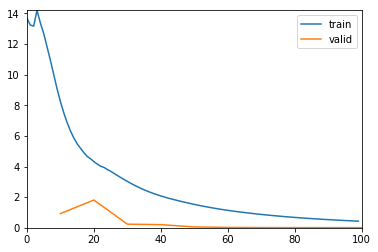

In [ ]:
#slow
learn = synth_learner(cbs=ShowGraphCallback())
learn.fit(10)

## CSVLogger -

In [ ]:
class CSVLogger(Callback):
    order=30 #Need to run after the recorder
    "Log the results displayed in `learn.path/fname`"
    def __init__(self, fname='history.csv', append=False): 
        self.fname,self.append = Path(fname),append

    def read_log(self):  
        "Convenience method to quickly access the log."
        return pd.read_csv(self.path/self.fname)

    def begin_fit(self):
        "Prepare file with metric names."
        self.path.parent.mkdir(parents=True, exist_ok=True)      
        self.file = (self.path/self.fname).open('a' if self.append else 'w')
        self.file.write(','.join(self.recorder.metric_names) + '\n')
        self.old_logger,self.learn.logger = self.logger,self._write_line
    
    def _write_line(self, log):
        "Write a line with `log` and call the old logger."
        self.file.write(','.join([str(t) for t in log]) + '\n')
        self.old_logger(log)
        
    def after_fit(self):  
        "Close the file and clean up."
        self.file.close()
        self.learn.logger = self.old_logger

The results are appened to an existing file if `append`, or they overwrite it otherwise.

In [ ]:
learn = synth_learner(cbs=CSVLogger())
learn.fit(5)

epoch,train_loss,valid_loss,time
0,2.472604,0.407792,00:00
1,0.113209,0.342660,00:00
2,0.235438,0.150912,00:00
3,0.035930,0.013605,00:00
4,0.027656,0.025660,00:00


In [ ]:
show_doc(CSVLogger.read_log)

<h4 id="<code>CSVLogger.read_log</code>" class="doc_header"><code>CSVLogger.read_log</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L7" class="source_link" style="float:right">[source]</a></h4>

> <code>CSVLogger.read_log</code>()

Convenience method to quickly access the log.

In [ ]:
df = learn.csv_logger.read_log()
test_eq(df.columns.values, learn.recorder.metric_names)
for i,v in enumerate(learn.recorder.values):
    test_close(df.iloc[i][:3], [i] + v)
os.remove(learn.path/learn.csv_logger.fname)

In [ ]:
show_doc(CSVLogger.begin_fit)

<h4 id="<code>CSVLogger.begin_fit</code>" class="doc_header"><code>CSVLogger.begin_fit</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>CSVLogger.begin_fit</code>()

Prepare file with metric names.

In [ ]:
show_doc(CSVLogger.after_fit)

<h4 id="<code>CSVLogger.after_fit</code>" class="doc_header"><code>CSVLogger.after_fit</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L23" class="source_link" style="float:right">[source]</a></h4>

> <code>CSVLogger.after_fit</code>()

Close the file and clean up.

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_augmentation.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 13_callback_schedule.ipynb.
Converted 14_callback_hook.ipynb.
Converted 15_callback_progress.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
